In [1]:
%load_ext autoreload
%autoreload 2
import pointCollection as pc
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import h5py
%matplotlib notebook
from ATL11.RDE import RDE
import scipy.interpolate as si
import os
from ATL11.rtw_mask import rtw_mask_for_delta_time
data_root='/Volumes/ice2/ben/MAR/ATL11_with_corrections/'


In [2]:
#masks:
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_nmad_lt_20_simplified.tif')
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')

<IPython.core.display.Javascript object>


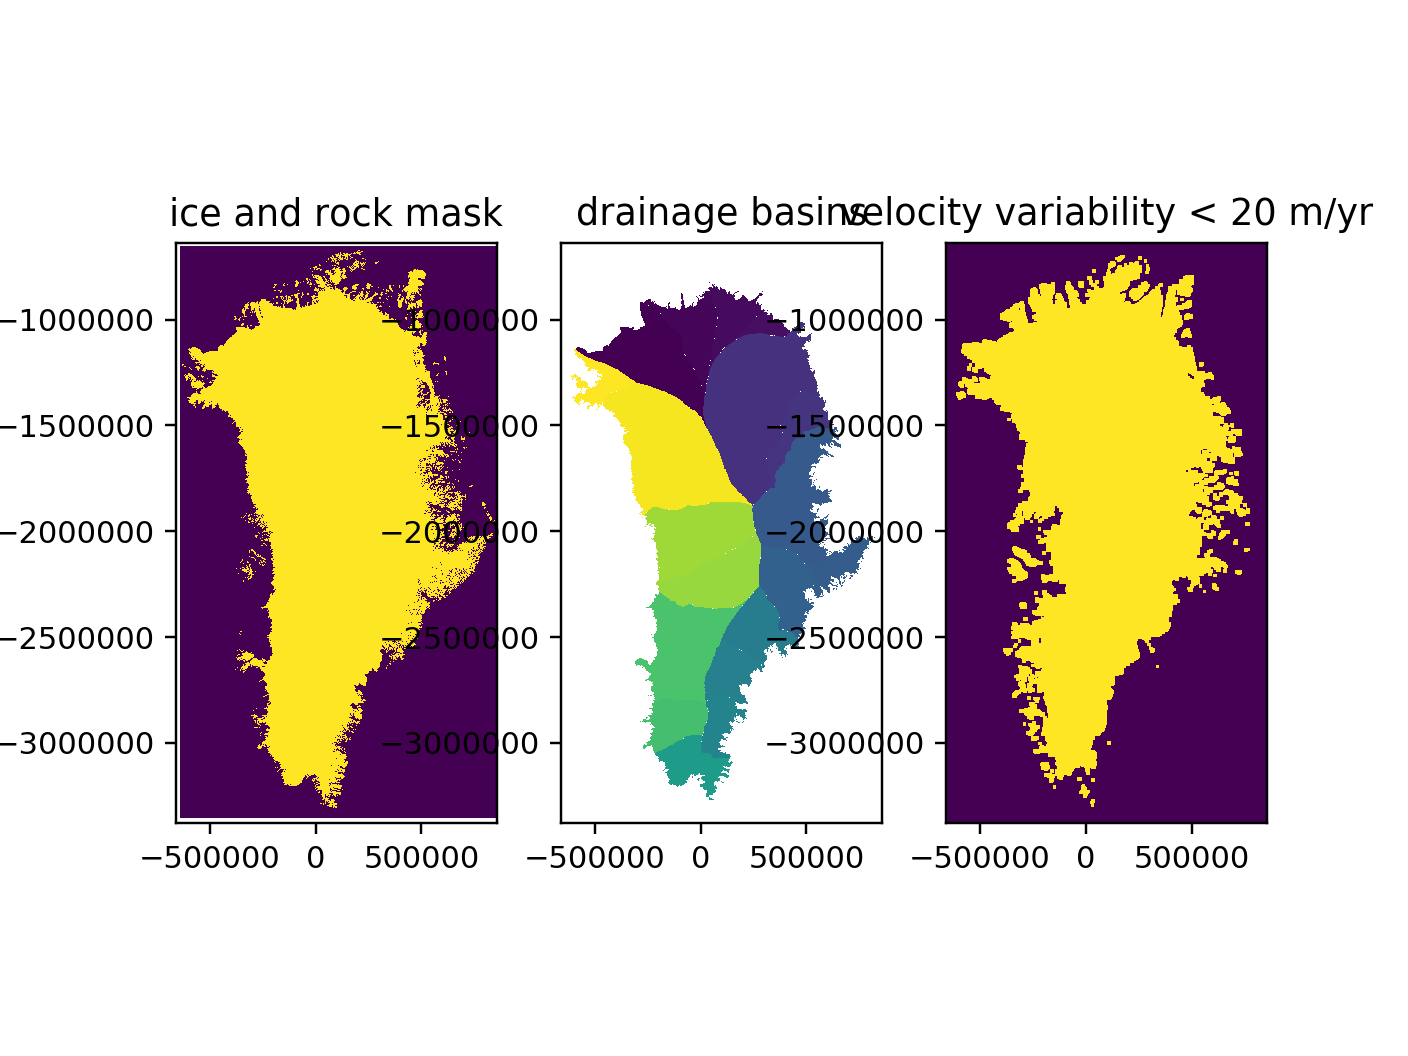

{'extent': array([ -639500.,   855500., -3355050.,  -656050.]), 'origin': 'lower'}
{'extent': array([ -640000.,   850000., -3350000.,  -660000.]), 'origin': 'lower'}
{'extent': array([ -659000.,   857000., -3379000.,  -640000.]), 'origin': 'lower'}


Text(0.5, 1.0, 'velocity variability < 20 m/yr')

In [3]:
fig=plt.figure(1); plt.clf()
fig.clf(); hax=[]
hax.append(fig.add_subplot(131))
gimp_mask.show(ax=hax[0])
hax[-1].set_title('ice and rock mask')
hax.append(fig.add_subplot(132, sharex=hax[0], sharey=hax[0]))
drainage_basins.show(ax=hax[1])
hax[-1].set_title('drainage basins')
hax.append(fig.add_subplot(133, sharex=hax[0], sharey=hax[0]))
v_mask.show(ax=hax[2])
hax[-1].set_title('velocity variability < 20 m/yr')

<IPython.core.display.Javascript object>


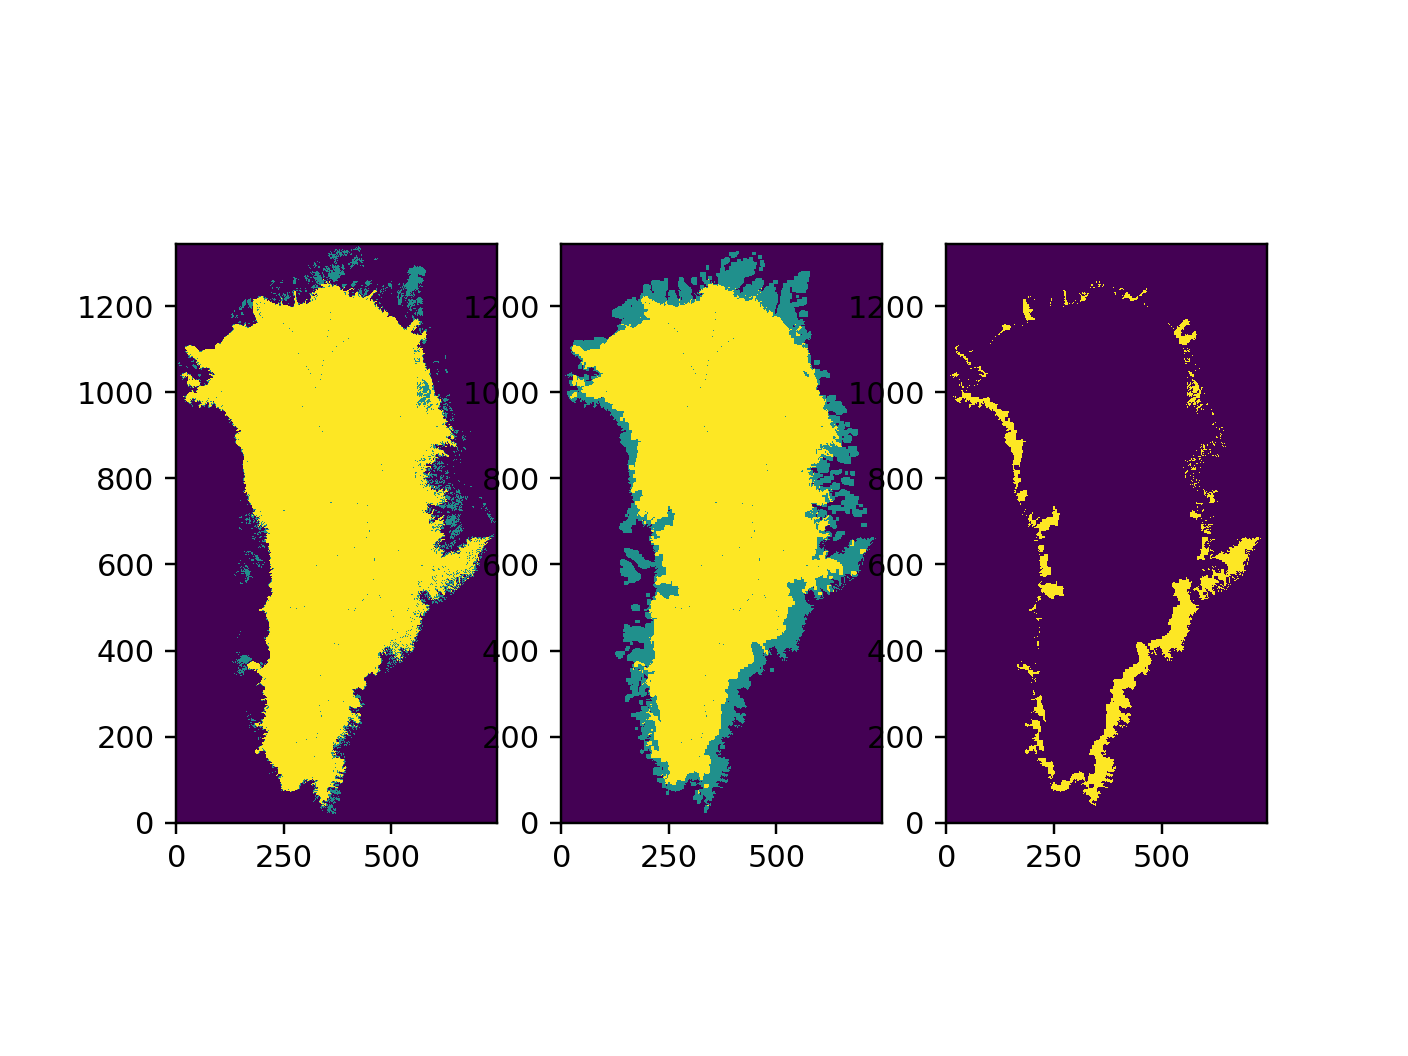

In [4]:
fig=plt.figure(2); plt.clf()
fig.clf(); hax=[]
db_mask=drainage_basins.copy()
db_mask.z=np.isfinite(db_mask.z)
temp=gimp_mask.interp(db_mask.x, db_mask.y, gridded=True)
hax.append(fig.add_subplot(131))
plt.imshow(np.isfinite(drainage_basins.z).astype(float) -(temp<0.5).astype(float), origin='lower')
db_mask.z[np.where(temp<0.5)]=0
temp=v_mask.interp(db_mask.x, db_mask.y, gridded=True)
hax.append(fig.add_subplot(132))
plt.imshow(np.isfinite(drainage_basins.z).astype(float) -(temp<0.5).astype(float), origin='lower')
db_mask.z[np.where(temp<0.5)]=0
hax.append(fig.add_subplot(133))
plt.imshow(np.isfinite(drainage_basins.z).astype(float)-db_mask.z.astype(float), origin='lower')



In [5]:

temp=np.isfinite(drainage_basins.z).astype(float)-db_mask.z.astype(float)
F_eliminated = np.sum(temp!=0)/np.sum(np.isfinite(drainage_basins.z) & (drainage_basins.z>0))

print(f"Masking removed {100*F_eliminated}% of the ice sheet")

Masking removed 12.065316209479825% of the ice sheet


In [6]:
#xo_file=data_root+'/U07_crossover_data.h5'
xo_file='/Volumes/ice1/tyler/U07_crossover_data.h5'
with h5py.File(xo_file,'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['x'].shape)

xo_cols=7
xo_cycles=np.arange(8)
at_file='/Volumes/ice1/tyler/relU07_dump_every_4th.h5'
#at_file=data_root+'/relU07_dump_every_4th.h5'
with h5py.File(at_file,'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['x'].shape)

at_cols=5
at_cycles=np.arange(3, 8)

['GSFC-fdm-v1', 'GSFC-fdm-v1.1', 'MARv3.11-ERA', 'MARv3.11.2-ERA-10km', 'MARv3.11.2-ERA-15km', 'MARv3.11.2-ERA-20km', 'MARv3.11.2-ERA-7.5km', 'MARv3.11.2-NCEP-20km', 'RACMO2.3p2-FGRN055', 'along_track_rss', 'atl06_quality_summary', 'cycle_number', 'delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'ref_pt', 'rgt', 'x', 'y']
(14131400, 7, 2)
['GSFC-fdm-v1', 'GSFC-fdm-v1.1', 'MARv3.11-ERA', 'MARv3.11.2-ERA-10km', 'MARv3.11.2-ERA-15km', 'MARv3.11.2-ERA-20km', 'MARv3.11.2-ERA-7.5km', 'MARv3.11.2-NCEP-20km', 'RACMO2.3p2-FGRN055', 'delta_time', 'dem_h', 'file_ind', 'h_corr', 'h_corr_sigma', 'latitude', 'longitude', 'quality_summary', 'x', 'y']
(10630392, 5)


In [7]:
D_xo=pc.data(columns=xo_cols).from_h5(xo_file, field_dict={None:['along_track_rss', 'atl06_quality_summary', \
            'cycle_number','delta_time', 'h_corr', 'h_corr_sigma', \
            'latitude', 'ref_pt', 'rgt','x','y']})
# remove data for which the PS projection gave weird results
bad=np.abs(D_xo.x) > 1.e8
D_xo.x[bad]=np.NaN
D_xo.x=np.nanmax(np.nanmax(D_xo.x, axis=1), axis=1)
D_xo.y[bad]=np.NaN
D_xo.y=np.nanmax(np.nanmax(D_xo.y, axis=1), axis=1)

In [8]:
SMB_list=['MARv3.11-ERA', 'MARv3.11.2-ERA-10km','MARv3.11.2-ERA-20km', \
            'MARv3.11.2-NCEP-20km', 'GSFC-fdm-v1']

SMB_fields=[]
with h5py.File(xo_file,'r') as h5f:
    for SMB_field in SMB_list:
        smb_field_name=SMB_field.replace('.','_').replace('-','_')+'_zsurf'
        D_xo.assign({smb_field_name:np.array(h5f[SMB_field]['zsurf'])})
        SMB_fields.append(smb_field_name)            
        if 'zsurf_ave' in h5f[SMB_field]:
            smb_field_name=SMB_field.replace('.','_').replace('-','_')+'_zsurf_ave'
            SMB_fields.append(smb_field_name)
            D_xo.assign({smb_field_name:np.array(h5f[SMB_field]['zsurf_ave'])})
        if 'smb_mean' in h5f[SMB_field]:
            smb_field_name=SMB_field.replace('.','_').replace('-','_')+'_smb_mean'
            SMB_fields.append(smb_field_name)
            D_xo.assign({smb_field_name:np.array(h5f[SMB_field]['smb_mean'])})
            print(f"{smb_field_name}:{np.mean(np.isfinite(getattr(D_xo, smb_field_name)), axis=0)}")

MARv3_11_2_ERA_10km_smb_mean:[[0.         0.17769039]
 [0.         0.2574965 ]
 [0.45454909 0.22761   ]
 [0.2498889  0.12400682]
 [0.53075612 0.12927403]
 [0.56246387 0.26116507]
 [0.04407129 0.02301697]]
MARv3_11_2_ERA_20km_smb_mean:[[0.         0.18074076]
 [0.         0.26019934]
 [0.45961702 0.22970569]
 [0.25228265 0.12511513]
 [0.53679267 0.13063844]
 [0.56917255 0.26387541]
 [0.04461108 0.02321964]]
MARv3_11_2_NCEP_20km_smb_mean:[[0.         0.18074076]
 [0.         0.26019934]
 [0.45961702 0.22970569]
 [0.25228265 0.12511513]
 [0.53679267 0.13063844]
 [0.56917255 0.26387541]
 [0.04461108 0.02321964]]


In [9]:
D_at=pc.data(columns=at_cols).from_h5(at_file, \
            field_dict={None:['x','y','delta_time','quality_summary','h_corr','h_corr_sigma','dem_h','rgt']})
with h5py.File(at_file,'r') as h5f:
    for SMB_field in SMB_list:
        smb_field_name=SMB_field.replace('.','_').replace('-','_')+'_zsurf'
        D_at.assign({smb_field_name:np.array(h5f[SMB_field]['zsurf'])})
        if 'zsurf_ave' in h5f[SMB_field]:
            smb_field_name=SMB_field.replace('.','_').replace('-','_')+'_zsurf_ave'
            D_at.assign({smb_field_name:np.array(h5f[SMB_field]['zsurf_ave'])})        
        if 'smb_mean' in h5f[SMB_field]:
            smb_field_name=SMB_field.replace('.','_').replace('-','_')+'_smb_mean'
            D_at.assign({smb_field_name:np.array(h5f[SMB_field]['smb_mean'])})
            print(f"{smb_field_name}:{np.mean(np.isfinite(getattr(D_at, smb_field_name)), axis=0)}")
            
sub_ind=np.arange(0, D_at.shape[0], 5, dtype='int')    
D_at.index(sub_ind);


MARv3_11_2_ERA_10km_smb_mean:[0.50637634 0.2923546  0.58856682 0.62696145 0.04926695]
MARv3_11_2_ERA_20km_smb_mean:[0.51001534 0.29409762 0.59297992 0.63191621 0.04963326]
MARv3_11_2_NCEP_20km_smb_mean:[0.51001534 0.29409762 0.59297992 0.63191621 0.04963326]


In [10]:
D_xo.index((D_xo.x > drainage_basins.x[0]) & (D_xo.x < drainage_basins.x[-1]) & (D_xo.y > drainage_basins.y[0]) & (D_xo.y < drainage_basins.y[-1]))
D_at.index((D_at.x[:,0] > drainage_basins.x[0]) & (D_at.x[:,0] < drainage_basins.x[-1]) & (D_at.y[:,0] > drainage_basins.y[0]) & (D_at.y[:,0] < drainage_basins.y[-1]))

dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')
D_xo.assign({'basin':np.round(dbi.__call__((D_xo.y, D_xo.x))*10)/10})
D_at.assign({'basin':np.round(dbi.__call__((D_at.y[:,0], D_at.x[:,0]))*10)/10});

In [11]:
# mask out non-ice areas
D_at.assign({'ice_mask':np.round(gimp_mask.interp(D_at.x[:,0], D_at.y[:,0])*10)/10});
D_xo.assign({'ice_mask':np.round(gimp_mask.interp(D_xo.x, D_xo.y)*10)/10})

<class 'pointCollection.data.data'> with shape (9931448, 7, 2),
with fields:
['along_track_rss', 'atl06_quality_summary', 'cycle_number', 'delta_time', 'h_corr', 'h_corr_sigma', 'latitude', 'ref_pt', 'rgt', 'x', 'y', 'MARv3_11_ERA_zsurf', 'MARv3_11_2_ERA_10km_zsurf', 'MARv3_11_2_ERA_10km_smb_mean', 'MARv3_11_2_ERA_20km_zsurf', 'MARv3_11_2_ERA_20km_smb_mean', 'MARv3_11_2_NCEP_20km_zsurf', 'MARv3_11_2_NCEP_20km_smb_mean', 'GSFC_fdm_v1_zsurf', 'basin', 'ice_mask']

In [12]:
# mask based on the speed variability
D_at.assign({'vel_mask':np.round(v_mask.interp(D_at.x[:,0], D_at.y[:,0])*10)/10});
D_xo.assign({'vel_mask':np.round(v_mask.interp(D_xo.x, D_xo.y)*10)/10});

In [13]:
# filter bad dh values from D_at
bad=(np.abs(D_at.h_corr-D_at.dem_h)>100) | np.tile(np.abs(D_at.ice_mask[:, None]-1)>0.01, [1, at_cols]) 
bad |= np.tile(np.abs(D_at.vel_mask[:, None]-1)>0.01, [1, at_cols]) 
bad |= np.tile(~np.isfinite(D_at.basin[:, None]), [1,5])
bad |= D_at.quality_summary > 6
bad |= rtw_mask_for_delta_time(D_at.delta_time)==0

D_at.h_corr[bad]=np.NaN

In [14]:
# filter bad dh values from D_xo
bad= np.tile(np.abs(D_xo.ice_mask[:, None]-1)>0.01, [1, xo_cols]) 
bad |= np.tile(np.abs(D_xo.vel_mask[:, None]-1)>0.01, [1, xo_cols]) 
bad |= np.tile(~np.isfinite(D_xo.basin[:, None]), [1, xo_cols])
bad |= np.any(D_xo.atl06_quality_summary==1, axis=2)
bad |= np.any(rtw_mask_for_delta_time(D_xo.delta_time)==0, axis=2)
temp=D_xo.h_corr.copy()
temp[:,:,0][bad]=np.NaN
temp[:,:,1][bad]=np.NaN
D_xo.h_corr=temp
#np.mean(bad[np.isfinite(D_xo.h_corr)])
#D_xo.h_corr[bad]=np.NaN

In [15]:
[ff for ff in D_xo.fields if ff not in D_at.fields]

['along_track_rss',
 'atl06_quality_summary',
 'cycle_number',
 'latitude',
 'ref_pt']

In [16]:
# reduce the xover fields
delta_data={}
block_scale=2500
#{field: getattr(D_xo, field).shape for field in D_xo.fields}
f_1col=['x','y','basin']
f_delta=['h_corr']
models=SMB_fields
#['MARv3_11_ERA_zsurf', 'MARv3_11_2_ERA_10km_zsurf',\
# 'MARv3_11_2_NCEP_20km_zsurf']

strings_xover = ['2018.Q4-2019.Q2','2019.Q1-2019.Q2']
xover_cols=[0, 1]
d_delta_t = 10*24*3600

for model in models.copy():    
    if 'smb_mean' in model:
        continue
    print(model)
    if model not in D_xo.fields:
        print(f"goodbye {model}")
        models.remove(model)
        continue
    delta_data[model]={}
    for col in [0, 1]:
        
        h_model=getattr(D_xo, model)
        
        h_data=0.5*(D_xo.h_corr[:, 2, 0]+D_xo.h_corr[:, col,1])
        dh_model=h_model[:, 2, 0]-h_model[:, col,1]            
        
        dh_data=(D_xo.h_corr[:, 2, 0]-D_xo.h_corr[:, col,1])
        smb_mean_field=model.replace('zsurf','smb_mean')
        if 'GSFC' not in model:
            if smb_mean_field not in models:
                if 'NCEP' in model:
                    smb_mean_field = 'MARv3_11_2_NCEP_20km_zsurf'
                else:
                    smb_mean_field = 'MARv3_11_2_ERA_10km_zsurf'
            dt_data = (D_xo.delta_time[:, 2, 0]-D_xo.delta_time[:, col, 1])/24/3600/365.25
            dh_mean = dt_data * getattr(D_xo, smb_mean_field)[:, col,1]*.910
            dh_model -= dh_mean
            print(f'data valid: {np.mean(np.isfinite(dh_data))}, mean valid: {np.mean(np.isfinite(dh_mean))}')
        dh_corr=dh_data-dh_model
        tt0=D_xo.delta_time[:, col,1]
        tt1=D_xo.delta_time[:, 2,  0]

        good=np.isfinite(dh_corr)
        dh_corr=dh_corr[good]
        dh_data=dh_data[good]
        dh_model=dh_model[good]       
        h_data=h_data[good]
        tt0=tt0[good]
        tt1=tt1[good]
        
        xx=D_xo.x[good]
        yy=D_xo.y[good]
        
        # blockmedian in short-time increments:
        t_bin=np.round(D_xo.delta_time[good,col, 1]/d_delta_t)
        ut_bin=np.unique(t_bin[np.isfinite(t_bin)])
        ii=[]
        for ti in ut_bin:
            these=np.flatnonzero(t_bin==ti)
            temp=these[pc.pt_blockmedian(xx[these], yy[these], dh_corr[these], block_scale, index_only=True)]
            ii += [temp]
        ii=np.concatenate(ii, axis=0)    
        xm=0.5*(xx[ii[:,0]]+xx[ii[:,1]])
        ym=0.5*(yy[ii[:,0]]+yy[ii[:,1]])
        tt0m=0.5*(tt0[ii[:,0]]+tt0[ii[:,1]])
        tt1m=0.5*(tt1[ii[:,0]]+tt1[ii[:,1]])

        dh_data_m=0.5*(dh_data[ii[:,0]]+dh_data[ii[:,1]])
        dh_corr_m=0.5*(dh_corr[ii[:,0]]+dh_corr[ii[:,1]])
        h_m=0.5*(h_data[ii[:,0]]+h_data[ii[:,1]])
        basin=0.5*(D_xo.basin[good][ii[:,0]]+D_xo.basin[good][ii[:,1]])
        
        temp={
            'x':xm,
            'y':ym,
            'dh':dh_data_m,
            'h0':h_m,
            'dh_corr':dh_corr_m,
            'basin':np.round(basin*10)/10, 
            't0':tt0m,
            't1':tt1m
             }
        delta_data[model][strings_xover[col]]=pc.data().from_dict(temp)

MARv3_11_ERA_zsurf
data valid: 0.07888779158890023, mean valid: 0.16729061059374223
data valid: 0.1122250249913205, mean valid: 0.23998867033286586
MARv3_11_2_ERA_10km_zsurf
data valid: 0.07888779158890023, mean valid: 0.16729061059374223
data valid: 0.1122250249913205, mean valid: 0.23998867033286586
MARv3_11_2_ERA_20km_zsurf
data valid: 0.07888779158890023, mean valid: 0.1698802631801526
data valid: 0.1122250249913205, mean valid: 0.24229941092175078
MARv3_11_2_NCEP_20km_zsurf
data valid: 0.07888779158890023, mean valid: 0.1698802631801526
data valid: 0.1122250249913205, mean valid: 0.24229941092175078
GSFC_fdm_v1_zsurf


In [17]:
# reduce the along-track data:
strings_at=['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']
for model in models:
    if 'smb_mean' in model:
        continue
    for col in [0, 1, 2]:
        dh_data=D_at.h_corr[:, col+1]-D_at.h_corr[:,col]
        h_data=0.5*(D_at.h_corr[:, col+1]+D_at.h_corr[:,col])
        h_model=getattr(D_at, model)
        h_model[h_model==0]=np.NaN
        dh_model=(h_model[:,col+1]-h_model[:,col])
        smb_mean_field=model.replace('zsurf','smb_mean')
        if 'GSFC' not in model:
            if smb_mean_field not in models:
                if 'NCEP' in model:
                    smb_mean_field = 'MARv3_11_2_NCEP_20km_zsurf'
                else:
                    smb_mean_field = 'MARv3_11_2_ERA_10km_zsurf'
            dt_data = (D_at.delta_time[:, col+1]-D_at.delta_time[:, col])/24/3600/365.25
            dh_mean = dt_data * getattr(D_at, smb_mean_field)[:, col]*.910
            dh_model -= dh_mean
            print(f'data valid: {np.mean(np.isfinite(dh_data))}, mean valid: {np.mean(np.isfinite(dh_mean))}')
        
        dh_corr=dh_data-dh_model
        good=np.isfinite(dh_corr)
        dh_corr=dh_corr[good]
        dh_data=dh_data[good]
        dh_model=dh_model[good]
        h_data=h_data[good]
        xx=D_at.x[good,0]
        yy=D_at.y[good,0]
        tt0=D_at.delta_time[good,col]
        tt1=D_at.delta_time[good,col+1]

        # blockmedian in monthly increments:
        t_bin=np.round(D_at.delta_time[good,col]/d_delta_t)
        ut_bin=np.unique(t_bin[np.isfinite(t_bin)])
        ii=[]
        for ti in ut_bin:
            these=np.flatnonzero(t_bin==ti)
            temp=these[pc.pt_blockmedian(xx[these], yy[these], dh_corr[these], block_scale, index_only=True)]
            ii += [temp]
        ii=np.concatenate(ii, axis=0)       
        
        xm=0.5*(xx[ii[:,0]]+xx[ii[:,1]]).ravel()
        ym=0.5*(yy[ii[:,0]]+yy[ii[:,1]]).ravel()
        dh_data_m=0.5*(dh_data[ii[:,0]]+dh_data[ii[:,1]]).ravel()
        dh_corr_m=0.5*(dh_corr[ii[:,0]]+dh_corr[ii[:,1]]).ravel()
        h_m=0.5*(h_data[ii[:,0]]+h_data[ii[:,1]])
        basin=0.5*(D_at.basin[good][ii[:,0]]+D_at.basin[good][ii[:,1]])
        t0m=0.5*(tt0[ii[:,0]]+tt0[ii[:,1]]).ravel()
        t1m=0.5*(tt1[ii[:,0]]+tt1[ii[:,1]]).ravel()

        temp={
            'x':xm,
            'y':ym,
            'dh':dh_data_m,
            'h0':h_m,
            'dh_corr':dh_corr_m,
            'basin':np.round(basin*10)/10,
            't0':t0m,
            't1':t1m
             }
        delta_data[model][strings_at[col]]=pc.data().from_dict(temp)


data valid: 0.14652847315395165, mean valid: 0.23902270961747793
data valid: 0.17118046661209146, mean valid: 0.2816713867656902
data valid: 0.3603498545755702, mean valid: 0.5970790916630692
data valid: 0.14652847315395165, mean valid: 0.23902270961747793
data valid: 0.17118046661209146, mean valid: 0.2816713867656902
data valid: 0.3603498545755702, mean valid: 0.5970790916630692
data valid: 0.14652847315395165, mean valid: 0.2401745212577616
data valid: 0.17118046661209146, mean valid: 0.28340895642521613
data valid: 0.3603498545755702, mean valid: 0.6015281059356216
data valid: 0.14652847315395165, mean valid: 0.2401745212577616
data valid: 0.17118046661209146, mean valid: 0.28340895642521613
data valid: 0.3603498545755702, mean valid: 0.6015281059356216


In [18]:
# pull out the cycle 3 - vs- subsequent cycles differences

# these are the same for the crossover cycles
delta_data_c3={}
for model in delta_data.keys():
    delta_data_c3[model]={}
    for epoch in strings_xover:
        delta_data_c3[model][epoch] = delta_data[model][epoch].copy()

strings_at=['2019.Q2-2019.Q3', '2019.Q2-2019.Q4', '2019.Q2-2020.Q1']
for model in models:
    if 'smb_mean' in model:
        continue
    for col in [1, 2, 3]:
        dh_data=D_at.h_corr[:, col]-D_at.h_corr[:,0]
        h_data=0.5*(D_at.h_corr[:, col]+D_at.h_corr[:,0])
        h_model=getattr(D_at, model)
        h_model[h_model==0]=np.NaN
        dh_model=(h_model[:,col]-h_model[:,0])

        smb_mean_field=model.replace('zsurf','smb_mean')
        if 'GSFC' not in model:
            if smb_mean_field not in models:
                if 'NCEP' in model:
                    smb_mean_field = 'MARv3_11_2_NCEP_20km_zsurf'
                else:
                    smb_mean_field = 'MARv3_11_2_ERA_10km_zsurf'
            dt_data = (D_at.delta_time[:, col]-D_at.delta_time[:, 0])/24/3600/365.25
            dh_mean = dt_data * getattr(D_at, smb_mean_field)[:, 0]*.910
            dh_model -= dh_mean
            print(f'data valid: {np.mean(np.isfinite(dh_data))}, mean valid: {np.mean(np.isfinite(dh_mean))}')

        dh_corr=dh_data-dh_model
        good=np.isfinite(dh_corr)
        dh_corr=dh_corr[good]
        dh_data=dh_data[good]
        dh_model=dh_model[good]
        h_data=h_data[good]
        xx=D_at.x[good,0]
        yy=D_at.y[good,0]
        tt0=D_at.delta_time[good,0]
        tt1=D_at.delta_time[good,col]
        
        # blockmedian in short-time increments:
        t_bin=np.round(D_at.delta_time[good,col]/d_delta_t)
        ut_bin=np.unique(t_bin[np.isfinite(t_bin)])
        ii=[]
        for ti in ut_bin:
            these=np.flatnonzero(t_bin==ti)
            temp=these[pc.pt_blockmedian(xx[these], yy[these], dh_corr[these], block_scale, index_only=True)]
            ii += [temp]
        ii=np.concatenate(ii, axis=0)       
        
        xm=0.5*(xx[ii[:,0]]+xx[ii[:,1]]).ravel()
        ym=0.5*(yy[ii[:,0]]+yy[ii[:,1]]).ravel()
        dh_data_m=0.5*(dh_data[ii[:,0]]+dh_data[ii[:,1]]).ravel()
        dh_corr_m=0.5*(dh_corr[ii[:,0]]+dh_corr[ii[:,1]]).ravel()
        h_m=0.5*(h_data[ii[:,0]]+h_data[ii[:,1]])
        basin=0.5*(D_at.basin[good][ii[:,0]]+D_at.basin[good][ii[:,1]])
        t0m=0.5*(tt0[ii[:,0]]+tt0[ii[:,1]]).ravel()
        t1m=0.5*(tt1[ii[:,0]]+tt1[ii[:,1]]).ravel()

        temp={
            'x':xm,
            'y':ym,
            'dh':dh_data_m,
            'h0':h_m,
            'dh_corr':dh_corr_m,
            'basin':np.round(basin*10)/10,
            't0':t0m,
            't1':t1m
             }
        delta_data_c3[model][strings_at[col-1]]=pc.data().from_dict(temp)


data valid: 0.14652847315395165, mean valid: 0.23902270961747793
data valid: 0.29151582352740973, mean valid: 0.4814530859177443
data valid: 0.3205660775051605, mean valid: 0.5255545146060344
data valid: 0.14652847315395165, mean valid: 0.23902270961747793
data valid: 0.29151582352740973, mean valid: 0.4814530859177443
data valid: 0.3205660775051605, mean valid: 0.5255545146060344
data valid: 0.14652847315395165, mean valid: 0.2401745212577616
data valid: 0.29151582352740973, mean valid: 0.4847455117262068
data valid: 0.3205660775051605, mean valid: 0.5292511791291015
data valid: 0.14652847315395165, mean valid: 0.2401745212577616
data valid: 0.29151582352740973, mean valid: 0.4847455117262068
data valid: 0.3205660775051605, mean valid: 0.5292511791291015


### Plot each epoch

In [20]:
models

['MARv3_11_ERA_zsurf',
 'MARv3_11_2_ERA_10km_zsurf',
 'MARv3_11_2_ERA_10km_smb_mean',
 'MARv3_11_2_ERA_20km_zsurf',
 'MARv3_11_2_ERA_20km_smb_mean',
 'MARv3_11_2_NCEP_20km_zsurf',
 'MARv3_11_2_NCEP_20km_smb_mean',
 'GSFC_fdm_v1_zsurf']

<IPython.core.display.Javascript object>


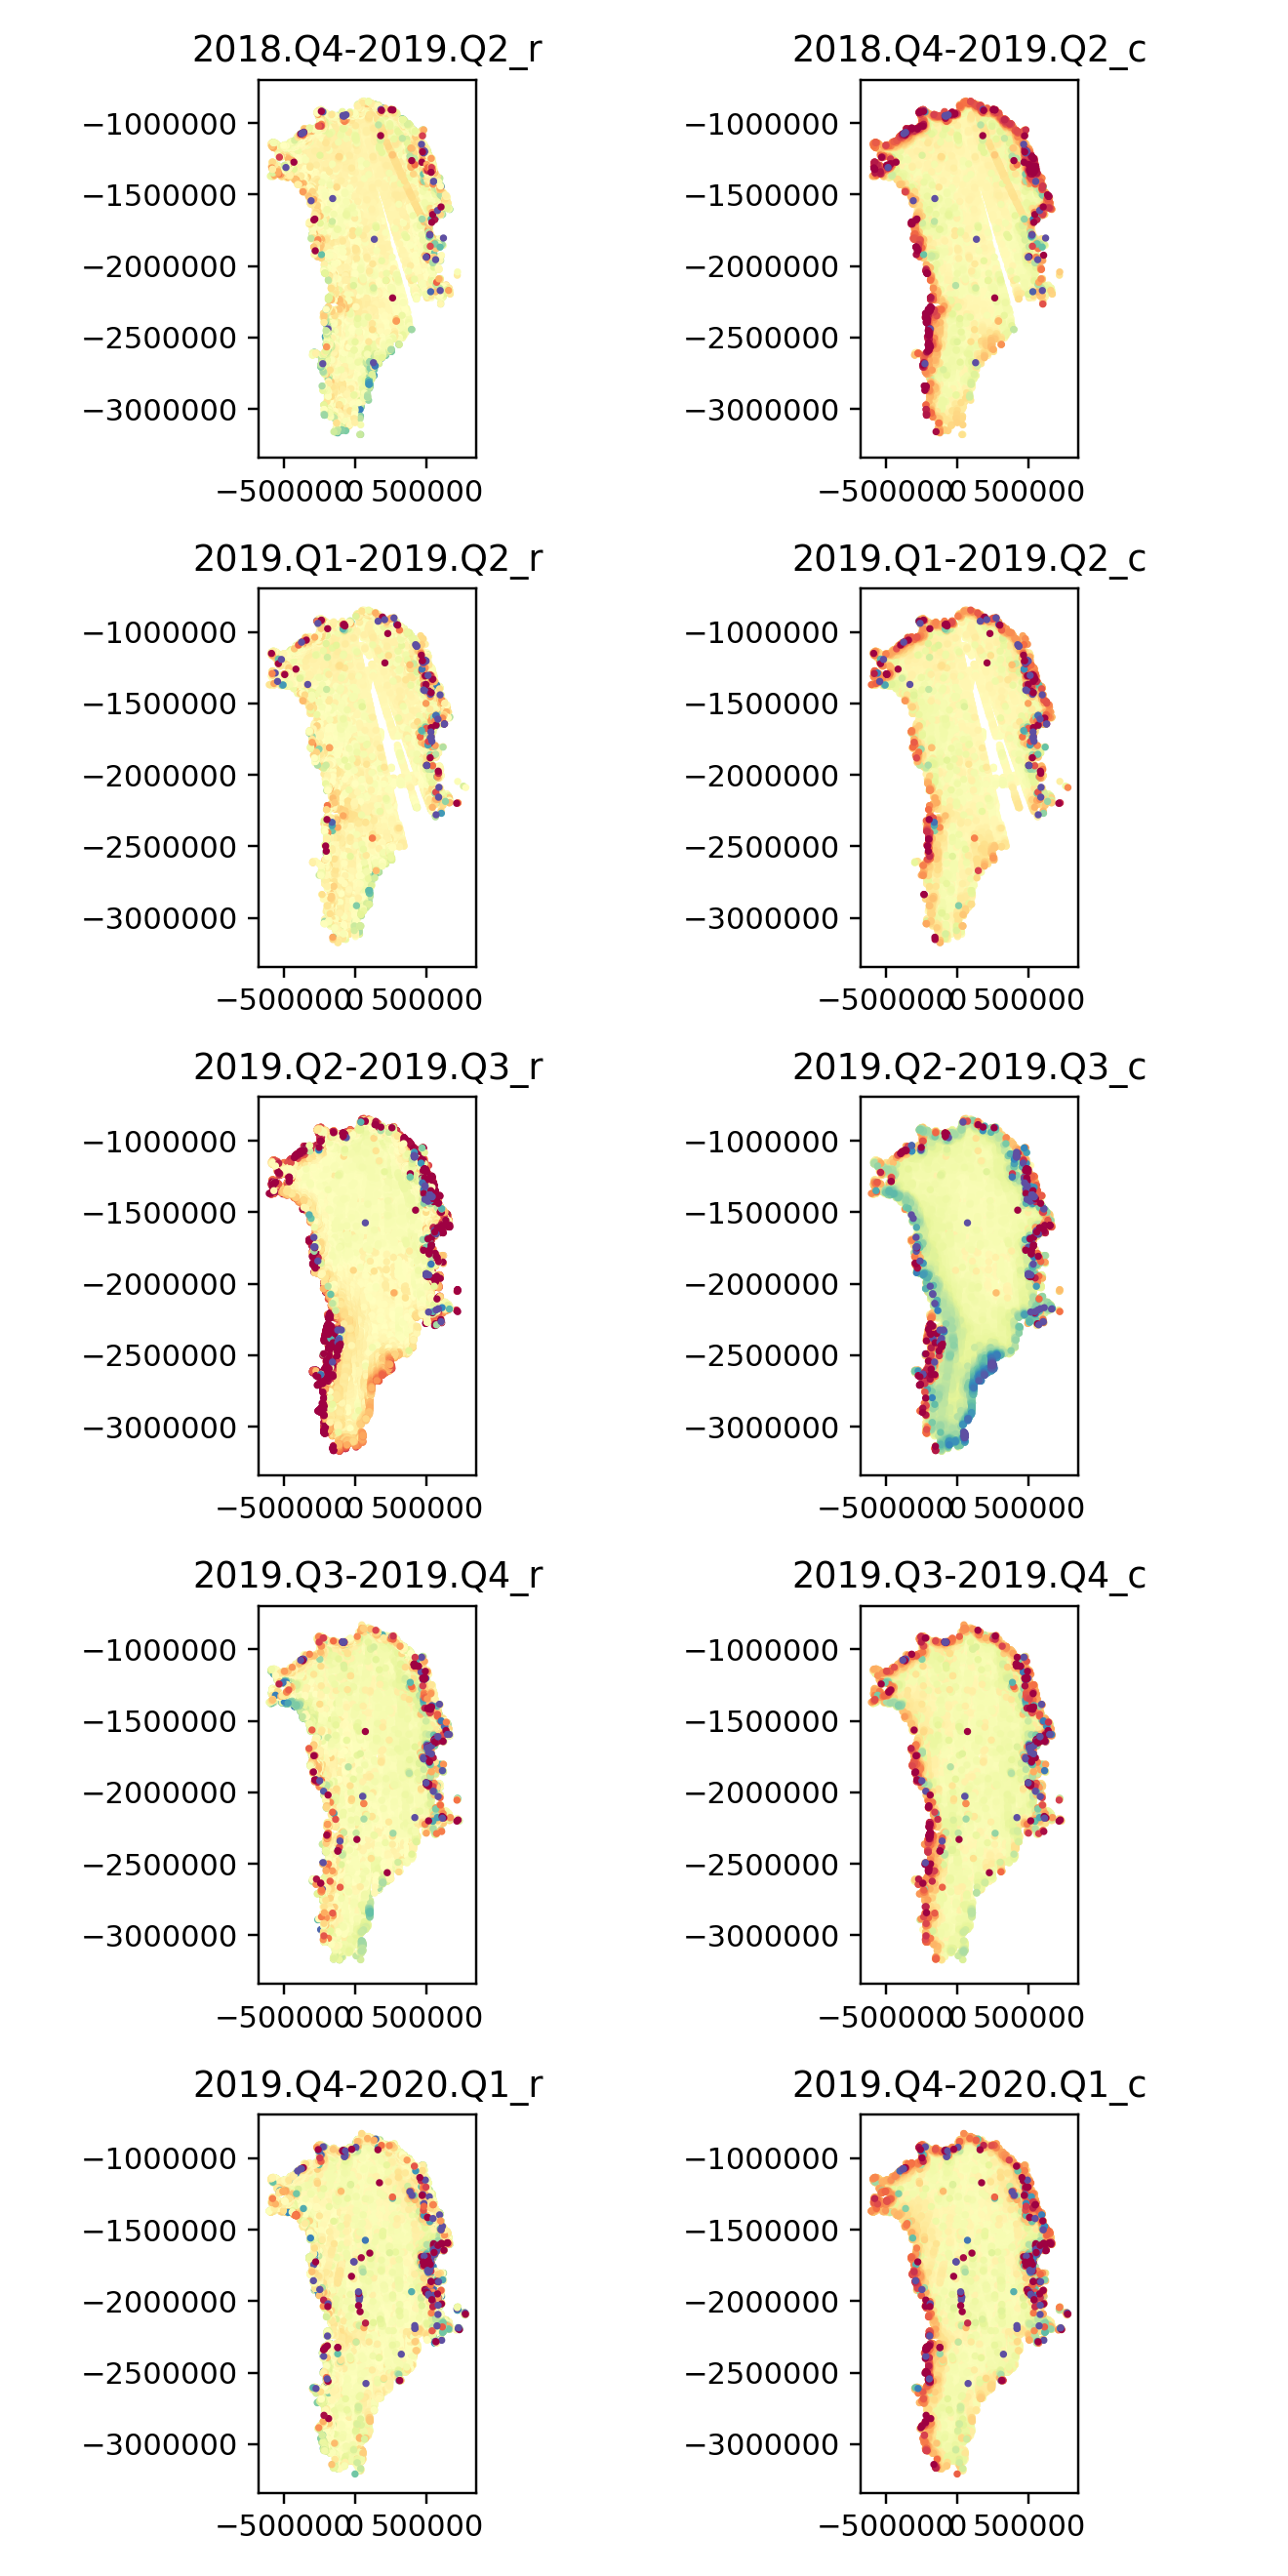

In [21]:
strings=strings_xover+['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']
#model='GSFC_fdm_v1_zsurf'
model='MARv3_11_2_NCEP_20km_zsurf'
fig=plt.figure(3, figsize=[6, 12])
fig.clf()
n_plots=5
hax=[[fig.add_subplot(n_plots, 2, 1, aspect='equal')]]
for col in range(n_plots):
    if col > 0:
        hax.append([])
    for ii in [0, 1]:
        if ii > 0 or col > 0:
            hax[col].append(fig.add_subplot(n_plots, 2, 2*col+ii+1, \
                                            sharex=hax[0][0], sharey=hax[0][0],\
                                           aspect='equal'))
D=delta_data[model]
for count, epoch in enumerate(strings):
    this_ax=hax[count][0]
    ind=np.argsort(np.abs(D[epoch].dh_corr))
    temp=D[epoch]
    this_ax.scatter(temp.x[ind], temp.y[ind], 2, c=temp.dh[ind],\
                     vmin=-2.5, vmax=2.5, cmap='Spectral');
    this_ax.set_title(epoch+'_r')
    this_ax=hax[count][1]
    this_ax.scatter(temp.x[ind], temp.y[ind], 2, c=temp.dh_corr[ind],\
                     vmin=-2.5, vmax=2.5, cmap='Spectral');
    this_ax.set_title(epoch+'_c')
plt.tight_layout()

In [22]:
out_file=data_root+'/combined_xover_at_differences.h5'
if os.path.isfile(out_file):
    os.remove(out_file)
for model in delta_data.keys():
    for epoch in delta_data[model]:
        delta_data[model][epoch].to_h5(out_file, group='/'+model+'/'+epoch, replace=False)

In [24]:
strings=strings_xover+['2019.Q2-2019.Q3', '2019.Q2-2019.Q4', '2019.Q2-2020.Q1']

model='GSFC_fdm_v1_zsurf'

fig=plt.figure(4, figsize=[6, 12])
fig.clf()
n_plots=5
hax=[[fig.add_subplot(n_plots, 2, 1, aspect='equal')]]
for col in range(n_plots):
    if col > 0:
        hax.append([])
    for ii in [0, 1]:
        if ii > 0 or col > 0:
            hax[col].append(fig.add_subplot(n_plots, 2, 2*col+ii+1, \
                                            sharex=hax[0][0], sharey=hax[0][0],\
                                           aspect='equal'))
D=delta_data_c3[model]
for count, epoch in enumerate(strings):
    this_ax=hax[count][0]
    ind=np.argsort(np.abs(D[epoch].dh_corr))
    temp=D[epoch]
    this_ax.scatter(temp.x[ind], temp.y[ind], 2, c=temp.dh[ind],\
                     vmin=-2.5, vmax=2.5, cmap='Spectral');
    this_ax.set_title(epoch+'_r')
    this_ax=hax[count][1]
    this_ax.scatter(temp.x[ind], temp.y[ind], 2, c=temp.dh_corr[ind],\
                     vmin=-2.5, vmax=2.5, cmap='Spectral');
    this_ax.set_title(epoch+'_c')
plt.tight_layout()

In [25]:
out_file=data_root+'/combined_xover_at_differences_wrtc3.h5'
if os.path.isfile(out_file):
    os.remove(out_file)
for model in delta_data_c3.keys():
    for epoch in delta_data_c3[model]:
        delta_data_c3[model][epoch].to_h5(out_file, group='/'+model+'/'+epoch, replace=False)

In [26]:
print(data_root)

/Volumes/ice2/ben/MAR/ATL11_with_corrections/


In [ ]:
! ls /Volumes/ice2/ben/MAR/ATL11_with_corrections/
